In [1]:
!pip install pandahouse -q

  Preparing metadata (setup.py) ... done


In [121]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np

In [5]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [6]:
def select(sql):
    return ph.read_clickhouse(sql, connection=connection_default)

In [7]:
sql = '''select count(*) from ldn_listings'''

In [8]:
select(sql)

,count()
0,85207


### Task 3

In [36]:
sql = '''select  toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price, room_type from ldn_listings order by id limit 1000'''

In [37]:
room_type_df = select(sql)

In [38]:
room_type_df.groupby('room_type').quantile(q=0.75)

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


### Task 4

In [49]:
sql = '''select  
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price, 
room_type,
toFloat32OrNull(review_scores_rating) as review_scores_rating
from ldn_listings
where review_scores_rating > 0
order by id
limit 1000'''

In [51]:
df4 = select(sql)

In [56]:
df4_gb = df4.groupby('room_type').agg({'price': 'mean', 'review_scores_rating': 'mean'})

<Axes: xlabel='price', ylabel='review_scores_rating'>

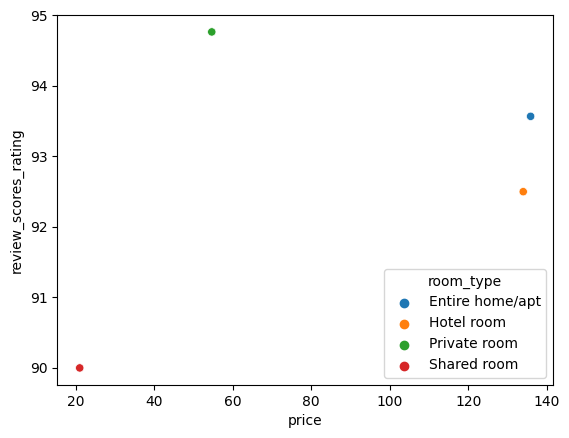

In [58]:
sns.scatterplot(data=df4_gb, x='price', y='review_scores_rating', hue='room_type')

### Task 5

In [95]:
sql = '''select
distinct(host_id) as host_id,
host_verifications
from ldn_listings
where experiences_offered != 'none'
order by id'''

In [96]:
df_5 = select(sql)
df_5

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [97]:
test = df_5['host_verifications'][0]
test

"['email', 'phone', 'facebook', 'reviews', 'offline_government_id', 'selfie', 'government_id']"

In [98]:
import re

In [99]:
print(re.sub(r"[\[\]\']", "", test).strip().split(', '))

['email', 'phone', 'facebook', 'reviews', 'offline_government_id', 'selfie', 'government_id']


In [100]:
df_5['host_verifications'] = df_5['host_verifications'].apply(lambda x: re.sub(r"[\[\]\']", "", x).strip().split(', '))

In [101]:
df_5.explode('host_verifications')['host_verifications'].value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

### Task 6

In [113]:
sql = '''
SELECT neighbourhood_cleansed,
experiences_offered,
count(experiences_offered) as experiences_count
from ldn_listings
where experiences_offered != 'none'
group by 
neighbourhood_cleansed,
experiences_offered
order by experiences_count desc
limit 100'''

In [114]:
df_6 = select(sql)
df_6

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [116]:
df_6_pivot = df_6.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
df_6_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


<Axes: xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

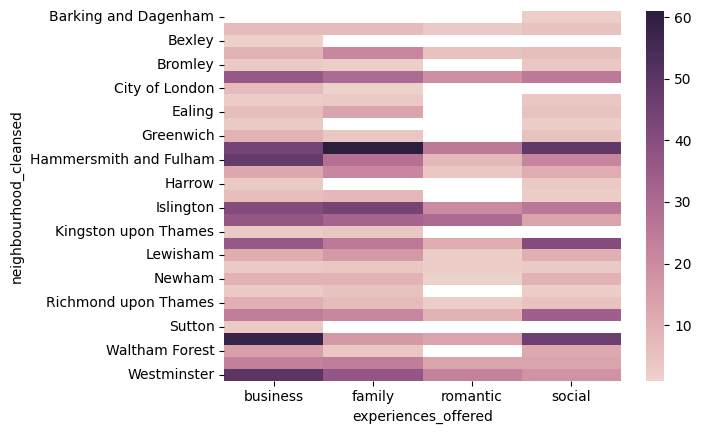

In [118]:
sns.heatmap(df_6_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

### Task 7

In [119]:
sql = '''SELECT
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
from ldn_listings
where experiences_offered != 'none'
'''


In [120]:
df_7 = select(sql)
df_7

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


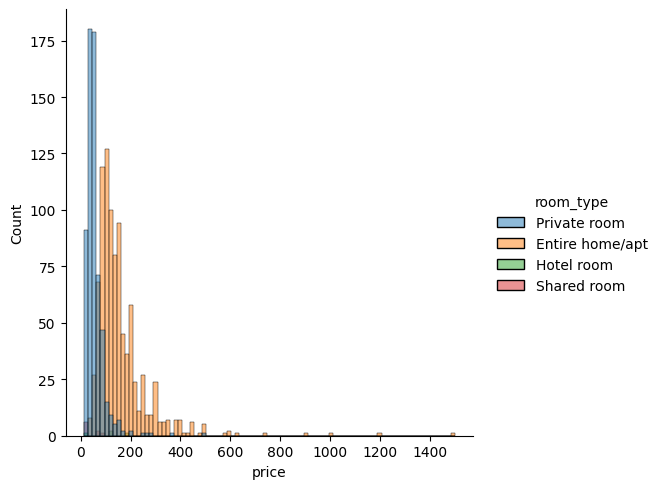

In [142]:
sns.displot(df_7, x='price', hue='room_type', kde=False)

In [146]:
df_log = df_7

In [147]:
df_log['price'] = df_7['price'].apply(lambda x: np.log(x))

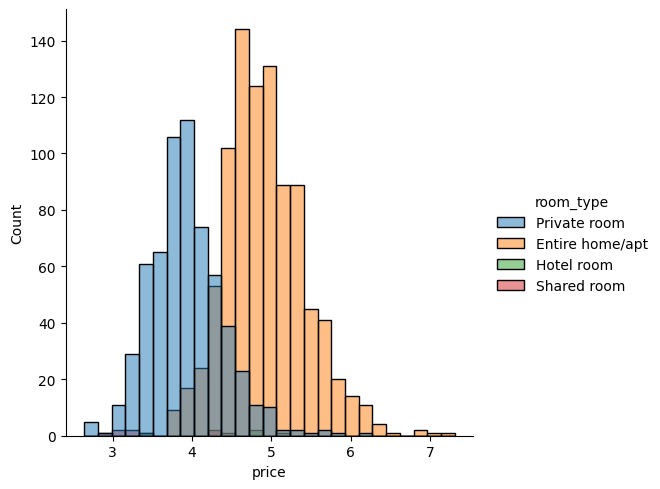

In [149]:
sns.displot(df_log, x='price', hue='room_type', kde=False)

### Task 8

In [164]:
sql = '''SELECT
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
first_review
from ldn_listings
where first_review > '2010-01-01'
limit 1000
'''

In [165]:
df_8 = select(sql)
df_8

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [166]:
df_8['first_review'] = pd.to_datetime(df_8['first_review'], format='%Y-%m-%d')

In [167]:
df_8['year'] = df_8['first_review'].dt.year

In [168]:
df_agg = df_8.groupby(['room_type', 'year'], as_index=False).agg({'price': 'mean'})

<Axes: xlabel='year', ylabel='price'>

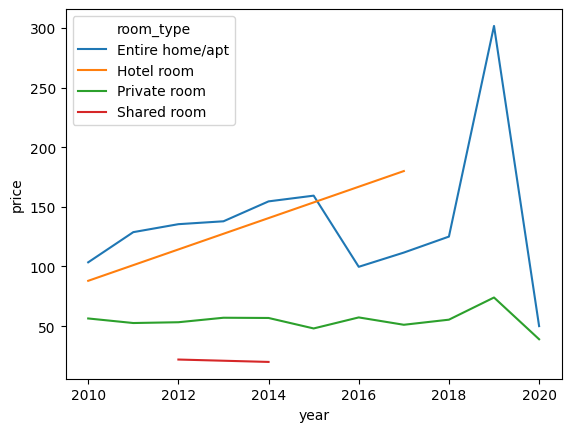

In [169]:
sns.lineplot(df_agg, x='year', y='price', hue='room_type')